In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn=sqlite3.connect('C:/Users/SKS/Desktop/AAIC/database.sqlite')
filtered_data=pd.read_sql_query('''SELECT * FROM REVIEWS WHERE SCORE!=3''',conn)


In [3]:
filtered_data.Score=filtered_data.Score.apply(lambda x:'positive' if x>3 else 'negative')

In [4]:
sorted_values=filtered_data.sort_values('ProductId',axis=0,ascending=True)
final=sorted_values.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [5]:
final['Time']=pd.to_datetime(final['Time'])
final=final.sort_values(by='Time',ascending=True)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1970-01-01 00:00:00.944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,1970-01-01 00:00:00.946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [6]:
final=final.iloc[:100000,:]

In [7]:
final.Score=final.Score.apply(lambda x:1 if x=='positive' else 0)

In [8]:
final.shape

(100000, 10)

# Text Preprocessing


In [9]:
import nltk
import re
def clean_html(sent):
    clean_text=re.sub(r"[<*.?>]",' ',sent)
    return clean_text

def clean_punc(sent):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sent)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

In [10]:
from tqdm import tqdm
import os

final_string=[]
for i,sent in enumerate(tqdm(final.Text.values)):
    filtered_sentence=[]
    sent=clean_html(sent)
    for w in sent.split():
        for word in clean_punc(w).split():
            if ((word.isalpha())&(len(word)>2)):
                if word.lower() not in stop:
                    s=(sno.stem(word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
    string=b' '.join(filtered_sentence)
    final_string.append(string)

final['Cleaned_Text']=final_string
final['Cleaned_Text']=final['Cleaned_Text'].str.decode('utf-8')

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:41<00:00, 985.35it/s]


In [11]:
from tqdm import tqdm
import os

final_string=[]
for i,sent in enumerate(tqdm(final.Summary.values)):
    filtered_sentence=[]
    sent=clean_html(sent)
    for w in sent.split():
        for word in clean_punc(w).split():
            if ((word.isalpha())&(len(word)>2)):
                if word.lower() not in stop:
                    s=(sno.stem(word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
    string=b' '.join(filtered_sentence)
    final_string.append(string)

final['Cleaned_Summary']=final_string
final['Cleaned_Summary']=final['Cleaned_Summary'].str.decode('utf-8')

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 14200.36it/s]


# Time Based Splitting

In [12]:
from sklearn.model_selection import train_test_split
X_train_text,X_test_text,y_train,y_test=train_test_split(final.Cleaned_Text,final.Score,test_size=0.30,shuffle=False)
X_train_summary,X_test_summary,y_train,y_test=train_test_split(final.Cleaned_Summary,final.Score,test_size=0.30,shuffle=False)

final.Score.value_counts()

1    87729
0    12271
Name: Score, dtype: int64

#### As we can see Our Data is Highly Imbalanced Positive class is far more than Negative Class

# Bag of Words Model

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
# Creating BOW for Text Column
cv_bow_text=CountVectorizer()
bow_X_train_text=cv_bow_text.fit_transform(X_train_text.values)
bow_X_test_text=cv_bow_text.transform(X_test_text.values)

In [14]:
# Creating BOW for Summary Column
cv_bow_summary=CountVectorizer(max_features=100,min_df=30)
bow_X_train_summary=cv_bow_summary.fit_transform(X_train_summary.values)
bow_X_test_summary=cv_bow_summary.transform(X_test_summary.values)

In [15]:
from scipy.sparse import hstack

bow_X_train=hstack([bow_X_train_text,bow_X_train_summary])
bow_X_test=hstack([bow_X_test_text,bow_X_test_summary])

In [16]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
bow_X_train=sc1.fit_transform(bow_X_train)
bow_X_test=sc1.transform(bow_X_test)

#  Linear SVM with SGD Classifier

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

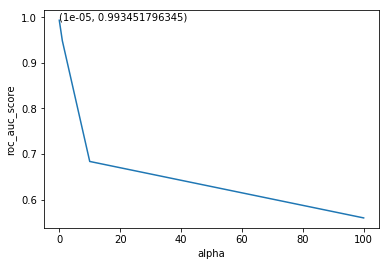

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
a=[0.00001, 0.0001, 0.001, 0.01, 1, 10, 100]
cv_score=[]
for i in a:
    classifier=SGDClassifier(alpha=i,loss='hinge',penalty='l2')
    caliberated_classifier=CalibratedClassifierCV(base_estimator=classifier, method='sigmoid', cv=5)
    caliberated_classifier.fit(bow_X_train,y_train)
    cv_score.append(roc_auc_score(y_train,caliberated_classifier.predict_proba(bow_X_train)[:,1]))

optimal_alpha=a[cv_score.index(max(cv_score))]
plt.plot(a,cv_score)
xy = (optimal_alpha, max(cv_score))
plt.annotate('(%s, %s)' % xy,xy=xy,textcoords='data')
plt.xlabel("alpha")
plt.ylabel("roc_auc_score")
plt.show()  


In [19]:
classifier=SGDClassifier(alpha=optimal_alpha,loss='hinge',penalty='l2')
classifier.fit(bow_X_train,y_train)

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

#### Optimal value of alpha is 0.00001



### Accuracy Metrics 

In [20]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score

In [21]:
pred_train=classifier.predict(bow_X_train)
pred_test=classifier.predict(bow_X_test)
accuracy_bow_train=accuracy_score(y_train,pred_train)*100
accuracy_bow_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_bow_train))
print("Testing Accuracy- {}%".format(accuracy_bow_test))
print("Training Error- {}%".format(100-accuracy_bow_train))
print("Testing Error- {}%".format(100-accuracy_bow_test))

Training Accuracy- 97.33714285714285%
Testing Accuracy- 89.63%
Training Error- 2.662857142857149%
Testing Error- 10.370000000000005%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 89.63%

### Classification Report 

In [22]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.62      0.63      0.62      4103
          1       0.94      0.94      0.94     25897

avg / total       0.90      0.90      0.90     30000



#### For Negative Reviews Recall is 0.63 or 63% which means out of all Actual Negative Points we are just predicting 63% of negative correctly which is bad while in Positive Reviews we are predicting 94% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low as compared to Positive Review(1)

### Confusion Matrix

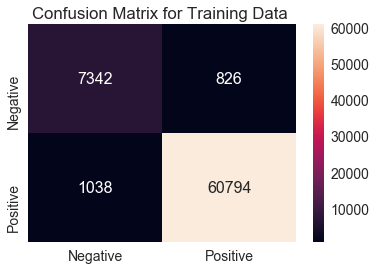

In [23]:
from sklearn.metrics import confusion_matrix,roc_curve
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

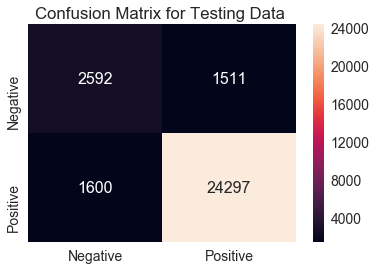

In [24]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 1511 negative reviews are predicted as positive

In [25]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR- {}".format(TPR))
print("FPR- {}".format(FPR))
print("TNR- {}".format(TNR))
print("FNR- {}".format(FNR))

TPR- 0.9414522628642281
FPR- 0.3816793893129771
TNR- 0.6183206106870229
FNR- 0.058547737135771855


### ROC AUC 

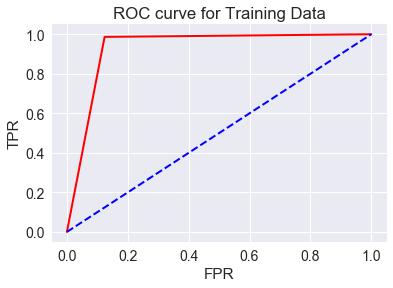

In [26]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

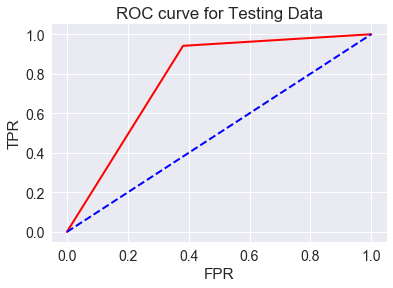

In [27]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

### Important Features

In [28]:
bow_features_text =cv_bow_text.get_feature_names()
bow_features_summary =cv_bow_summary.get_feature_names()
bow_features=bow_features_text+bow_features_summary
weights= classifier.coef_
feature_weights = pd.DataFrame(weights, columns = bow_features)
feature_weights=feature_weights.T
feature_weights.head()

,0
aaa,74.398297
aaaaaaaaagghh,0.000000
aaaaah,0.000000
aaaaahhhhhhhhhhhhhhhh,0.000000
aaaah,0.000000


In [29]:
feature_weights.shape

(31479, 1)

#### Important Features for Negative Review

In [30]:
feature_weights[0].sort_values(ascending = True)[0:10]

disappoint   -185.074735
worst        -175.020126
grainiest    -148.796595
occup        -128.863472
terribl      -125.542793
aw           -123.241219
disappoint   -122.791235
unfortun     -120.091188
tast         -116.415549
ane          -111.599838
Name: 0, dtype: float64

#### Important Features for Positive Review

In [31]:
feature_weights[0].sort_values(ascending = False)[0:10]

great      351.416632
great      343.881641
best       323.625552
excel      236.338779
love       235.109058
best       232.118593
delici     230.051232
love       229.987876
delici     224.813665
perfect    224.316086
Name: 0, dtype: float64

# TF-IDF Model

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
#TFIDF for Text 
tfidf_vect_text=TfidfVectorizer()
tfidf_X_train_text=tfidf_vect_text.fit_transform(X_train_text.values)
tfidf_X_test_text=tfidf_vect_text.transform(X_test_text.values)

#TFIDF for Summary
tfidf_vect_summary=TfidfVectorizer(max_features=100)
tfidf_X_train_summary=tfidf_vect_summary.fit_transform(X_train_summary.values)
tfidf_X_test_summary=tfidf_vect_summary.transform(X_test_summary.values)

from scipy.sparse import hstack

tfidf_X_train=hstack([tfidf_X_train_text,tfidf_X_train_summary])
tfidf_X_test=hstack([tfidf_X_test_text,tfidf_X_test_summary])

from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
tfidf_X_train=sc1.fit_transform(tfidf_X_train)
tfidf_X_test=sc1.transform(tfidf_X_test)

# Linear SVM using SGD Classifier

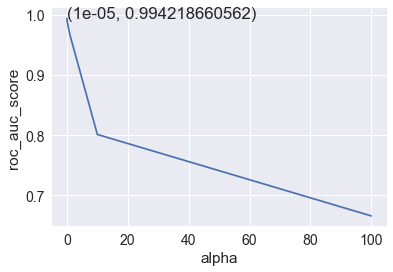

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
a=[0.00001, 0.0001, 0.001,0.01,0.1, 1, 10, 100]
cv_score=[]
for i in a:
    classifier=SGDClassifier(alpha=i,loss='hinge',penalty='l2')
    caliberated_classifier=CalibratedClassifierCV(base_estimator=classifier, method='sigmoid', cv=5)
    caliberated_classifier.fit(tfidf_X_train,y_train)
    cv_score.append(roc_auc_score(y_train,caliberated_classifier.predict_proba(tfidf_X_train)[:,1]))

optimal_alpha=a[cv_score.index(max(cv_score))]
plt.plot(a,cv_score)
xy = (optimal_alpha, max(cv_score))
plt.annotate('(%s, %s)' % xy,xy=xy,textcoords='data')
plt.xlabel("alpha")
plt.ylabel("roc_auc_score")
plt.show()  

classifier=SGDClassifier(alpha=optimal_alpha,loss='hinge',penalty='l2')
classifier.fit(tfidf_X_train,y_train)

#### Optimal Value of C is 0.00001



### Accuracy Metrics 

In [34]:
pred_train=classifier.predict(tfidf_X_train)
pred_test=classifier.predict(tfidf_X_test)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 97.30142857142857%
Testing Accuracy- 88.84666666666666%
Training Error- 2.6985714285714266%
Testing Error- 11.153333333333336%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 88.84%

In [35]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.59      0.60      0.59      4103
          1       0.94      0.93      0.94     25897

avg / total       0.89      0.89      0.89     30000



#### For Negative Reviews Recall is 0.60 or 60% which means out of all Actual Negative Points we are just predicting 60% of negative correctly which is bad while in Positive Reviews we are predicting 99% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also very low



### Confusion Matrix

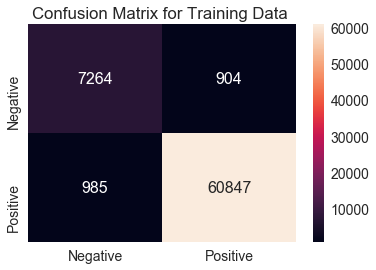

In [36]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

#### For Training Data TFIDF model is doing a great job as True Negative and True Positives are very high

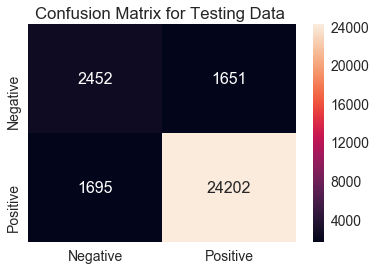

In [37]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicted more Negetive Reviews as Postive Reviews than Negative Reviews as Negative Reviews i.e. Out of 4098 Negative reviews we are predicting 1651 reviews as Positive 

#### TFIDF Model is predicting more False Positive with respect to BOW Model

In [38]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.9361389393880788
FPR-0.4087292018326501
TNR-0.5912707981673498
FNR-0.06386106061192125


### ROC AUC 

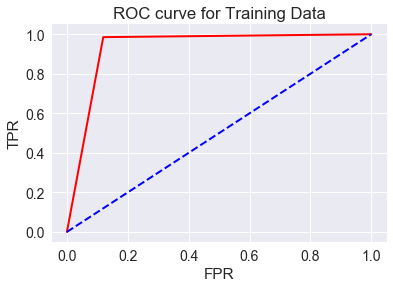

In [39]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

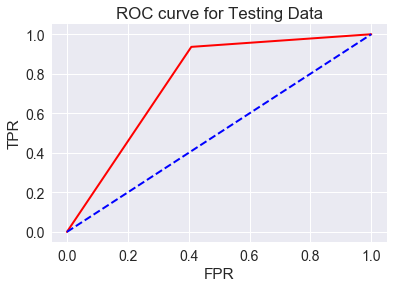

In [40]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

In [41]:
tfidf_features_text =tfidf_vect_text.get_feature_names()
tfidf_features_summary =tfidf_vect_summary.get_feature_names()
tfidf_features=tfidf_features_text+tfidf_features_summary
weights= classifier.coef_
feature_weights = pd.DataFrame(weights, columns = tfidf_features)
feature_weights=feature_weights.T
feature_weights.head()

,0
aaa,0.0
aaaaaaaaagghh,0.0
aaaaah,0.0
aaaaahhhhhhhhhhhhhhhh,0.0
aaaah,0.0


#### Important Features for Negative Review

In [42]:
feature_weights[0].sort_values(ascending = True)[0:10]

worst        -203.441953
disappoint   -175.602228
disappoint   -173.663753
aw           -128.889170
horribl      -128.481885
stale        -119.953235
unfortun     -115.394277
terribl      -114.853285
supervisor   -110.635670
hope         -109.395293
Name: 0, dtype: float64

#### Important Features for Positive Review

In [43]:
feature_weights[0].sort_values(ascending = False)[0:10]

great      428.168244
great      407.308111
best       356.960699
love       300.211604
best       297.294713
love       290.094497
excel      274.254587
delici     270.194684
yummi      265.715860
perfect    253.926768
Name: 0, dtype: float64

# Average Word2Vec Model

In [44]:
from gensim.models import Word2Vec
# Train Data for Text
list_of_sent_train_text=[]
for sent in X_train_text.values:
    list_of_sent_train_text.append(sent.split())
w2v_model_text=Word2Vec(list_of_sent_train_text,min_count=5,size=50, workers=4)
w2v_words_text = list(w2v_model_text.wv.vocab)
sent_vectors_train_text = []
for sent in tqdm(list_of_sent_train_text): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_text:
            vec = w2v_model_text.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_text.append(sent_vec)

# Test Data for Text
list_of_sent_test_text=[]
for sent in X_test_text.values:
    list_of_sent_test_text.append(sent.split())
sent_vectors_test_text = []
for sent in tqdm(list_of_sent_test_text): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_text:
            vec = w2v_model_text.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_text.append(sent_vec) 

#Train data for Summary
list_of_sent_train_summary=[]
for sent in X_train_summary.values:
    list_of_sent_train_summary.append(sent.split())
w2v_model_summary=Word2Vec(list_of_sent_train_summary,min_count=5,size=50, workers=4)
w2v_words_summary = list(w2v_model_summary.wv.vocab)
sent_vectors_train_summary = []
for sent in tqdm(list_of_sent_train_summary): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_summary:
            vec = w2v_model_summary.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_summary.append(sent_vec)

#Test data for Summary
list_of_sent_test_summary=[]
for sent in X_test_summary.values:
    list_of_sent_test_summary.append(sent.split())
sent_vectors_test_summary = []
for sent in tqdm(list_of_sent_test_summary): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_summary:
            vec = w2v_model_summary.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_summary.append(sent_vec) 

100%|█████████████████████████████████████████████████████████████████████████| 30000/30000 [00:01<00:00, 19566.97it/s]


In [45]:
sent_vectors_train_text=np.array(sent_vectors_train_text)
sent_vectors_test_text=np.array(sent_vectors_test_text)
sent_vectors_train_summary=np.array(sent_vectors_train_summary)
sent_vectors_test_summary=np.array(sent_vectors_test_summary)

In [46]:
sent_vectors_train=np.hstack((sent_vectors_train_text,sent_vectors_train_summary))
sent_vectors_test=np.hstack((sent_vectors_test_text,sent_vectors_test_summary))

In [47]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
sent_vectors_train=sc1.fit_transform(sent_vectors_train)
sent_vectors_test=sc1.transform(sent_vectors_test)

# Linear SVM with SGD Classifier

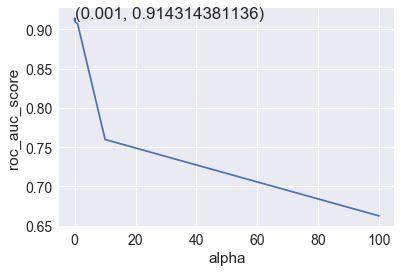

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB
a=[0.00001, 0.0001, 0.001,0.01,0.1, 1, 10, 100]
cv_score=[]
for i in a:
    classifier=SGDClassifier(alpha=i,loss='hinge',penalty='l2')
    caliberated_classifier=CalibratedClassifierCV(base_estimator=classifier, method='sigmoid', cv=5)
    caliberated_classifier.fit(sent_vectors_train,y_train)
    cv_score.append(roc_auc_score(y_train,caliberated_classifier.predict_proba(sent_vectors_train)[:,1]))

optimal_alpha=a[cv_score.index(max(cv_score))]
plt.plot(a,cv_score)
xy = (optimal_alpha, max(cv_score))
plt.annotate('(%s, %s)' % xy,xy=xy,textcoords='data')
plt.xlabel("alpha")
plt.ylabel("roc_auc_score")
plt.show()  

classifier=SGDClassifier(alpha=optimal_alpha,loss='hinge',penalty='l2')
classifier.fit(sent_vectors_train,y_train)

#### Optimal Value of C is 0.001

#### Testing ROC Score is 91.43%


In [49]:
pred_train=classifier.predict(sent_vectors_train)
pred_test=classifier.predict(sent_vectors_test)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 91.27285714285715%
Testing Accuracy- 90.11666666666667%
Training Error- 8.727142857142852%
Testing Error- 9.883333333333326%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 90.11%

In [50]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.78      0.38      0.52      4103
          1       0.91      0.98      0.94     25897

avg / total       0.89      0.90      0.89     30000



#### For Negative Reviews Recall is 0.38 or 38% which means out of all Actual Negative Points we are just predicting 38% of negative correctly which is bad while in Positive Reviews we are predicting 98% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low

### Confusion Matrix

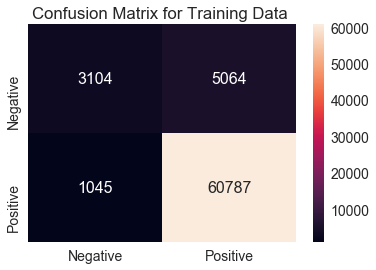

In [51]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

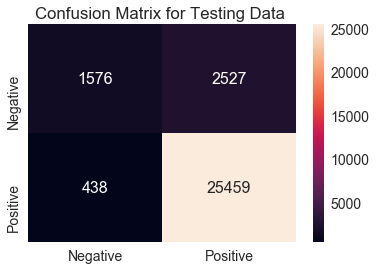

In [52]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 2527 negative reviews are predicted as positive

In [53]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.9097048524262131
FPR-0.21747765640516387
TNR-0.7825223435948362
FNR-0.0902951475737869


### ROC AUC 

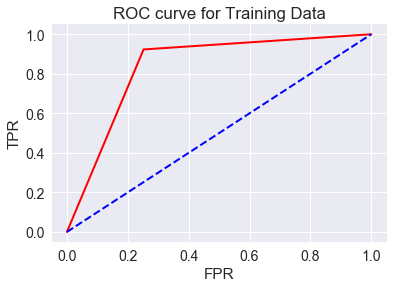

In [54]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

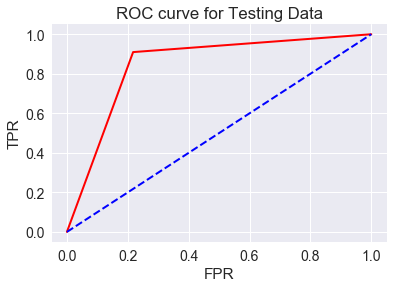

In [55]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

#### As Area under the Red Curve is mostly same for Training and Testing data which says Our model is good

# TFIDF Word2Vec Model

In [56]:
model_text = TfidfVectorizer()
tf_idf_matrix_text = model_text.fit_transform(X_train_text.values)

dictionary = dict(zip(model_text.get_feature_names(), list(model_text.idf_)))

tfidf_feat_text = model_text.get_feature_names() 
tfidf_sent_vectors_train_text = []
for sent in tqdm(list_of_sent_train_text): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_text):
            vec = w2v_model_text.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train_text.append(sent_vec)
    
tf_idf_matrix_text = model_text.transform(X_test_text.values)

dictionary = dict(zip(model_text.get_feature_names(), list(model_text.idf_)))

tfidf_feat_text = model_text.get_feature_names() 
tfidf_sent_vectors_test_text = []
for sent in tqdm(list_of_sent_test_text): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_text):
            vec = w2v_model_text.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test_text.append(sent_vec)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:52<00:00, 572.86it/s]


In [57]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
tfidf_sent_vectors_train_text=sc1.fit_transform(tfidf_sent_vectors_train_text)
tfidf_sent_vectors_test_text=sc1.transform(tfidf_sent_vectors_test_text)

# Linear SVM with SGD Classifier

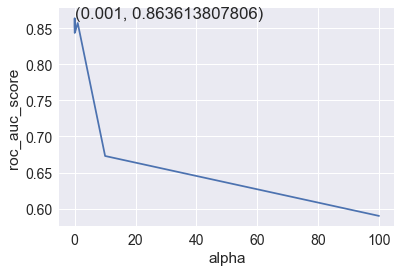

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB
a=[0.00001, 0.0001, 0.001,0.01,0.1, 1, 10, 100]
cv_score=[]
for i in a:
    classifier=SGDClassifier(alpha=i,loss='hinge',penalty='l2')
    caliberated_classifier=CalibratedClassifierCV(base_estimator=classifier, method='sigmoid', cv=5)
    caliberated_classifier.fit(tfidf_sent_vectors_train_text,y_train)
    cv_score.append(roc_auc_score(y_train,caliberated_classifier.predict_proba(tfidf_sent_vectors_train_text)[:,1]))

optimal_alpha=a[cv_score.index(max(cv_score))]
plt.plot(a,cv_score)
xy = (optimal_alpha, max(cv_score))
plt.annotate('(%s, %s)' % xy,xy=xy,textcoords='data')
plt.xlabel("alpha")
plt.ylabel("roc_auc_score")
plt.show()  

classifier=SGDClassifier(alpha=optimal_alpha,loss='hinge',penalty='l2')
classifier.fit(tfidf_sent_vectors_train_text,y_train)

#### Optimal value of C is 0.001

In [59]:
pred_train=classifier.predict(tfidf_sent_vectors_train_text)
pred_test=classifier.predict(tfidf_sent_vectors_test_text)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 89.21142857142857%
Testing Accuracy- 87.38666666666667%
Training Error- 10.78857142857143%
Testing Error- 12.61333333333333%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 87.38%

In [60]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.74      0.12      0.21      4103
          1       0.88      0.99      0.93     25897

avg / total       0.86      0.87      0.83     30000



#### For Negative Reviews Recall is 0.12 or 12% which means out of all Actual Negative Points we are just predicting 12% of negative correctly which is bad while in Positive Reviews we are predicting 98% of Reviews as Positive out of all Actual Positive Reviews

#### F1 Score for Negative Review(0) is also low

### Confusion Matrix

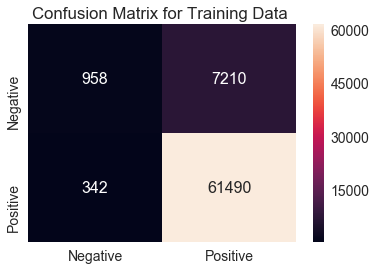

In [61]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

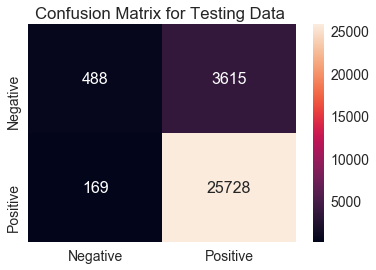

In [62]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 3615 negative reviews are predicted as positive

In [63]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.8768019629894693
FPR-0.2572298325722983
TNR-0.7427701674277016
FNR-0.12319803701053061


### ROC AUC 

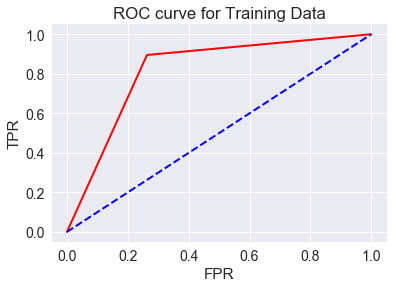

In [64]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

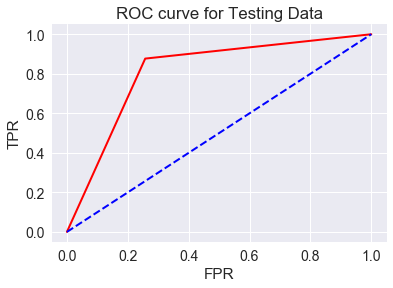

In [65]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

# Conclusion for Linear SVM
* We are using SGD Classfier with hinge loss as it is computationally less expensive then SVC(Linerar)
* As SGD Classifier Doesn't predict probabilities, and we need probabilities for roc auc score we are using caliberatedclassifiercv for CrossValidation
* From Above Analysis we can say BOW model is best for Amazaon Food Review data set 
* Accuracy can't be the best measure for this dataset as it is highly imabalanced
* BOW Model is Predicting less False Positives with respect to all other Models


#  RBF SVM 

In [87]:
final=final.iloc[:20000,:]


1    17826
0     2174
Name: Score, dtype: int64

# Time Based Splitting

In [67]:
from sklearn.model_selection import train_test_split
X_train_text,X_test_text,y_train,y_test=train_test_split(final.Cleaned_Text,final.Score,test_size=0.30,shuffle=False)
X_train_summary,X_test_summary,y_train,y_test=train_test_split(final.Cleaned_Summary,final.Score,test_size=0.30,shuffle=False)

final.Score.value_counts()

1    17826
0     2174
Name: Score, dtype: int64

#### As we can see Our Data is Highly Imbalanced Positive class is far more than Negative Class

# Bag of Words Model

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
# Creating BOW for Text Column
cv_bow_text=CountVectorizer(max_features=500,min_df=10)
bow_X_train_text=cv_bow_text.fit_transform(X_train_text.values)
bow_X_test_text=cv_bow_text.transform(X_test_text.values)

In [69]:
# Creating BOW for Summary Column
cv_bow_summary=CountVectorizer(max_features=30,min_df=10)
bow_X_train_summary=cv_bow_summary.fit_transform(X_train_summary.values)
bow_X_test_summary=cv_bow_summary.transform(X_test_summary.values)

In [70]:
from scipy.sparse import hstack

bow_X_train=hstack([bow_X_train_text,bow_X_train_summary])
bow_X_test=hstack([bow_X_test_text,bow_X_test_summary])

In [71]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
bow_X_train=sc1.fit_transform(bow_X_train)
bow_X_test=sc1.transform(bow_X_test)

In [72]:
bow_X_train.shape

(14000, 530)

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [74]:
tuned_parameters = [{'C': [10**-2, 10**-1, 10**0, 10**1],'gamma': [10**-2, 10**-1, 10**0, 10**1]}]
model = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'roc_auc')
model.fit(bow_X_train, y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(bow_X_test, y_test))

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training_ROC_AUC_Score- 0.834626155546
Testing_ROC_AUC_Score- 0.834453636752


#### Optimal C=0.01
#### Optimal gamma=0.01
#### Testing ROC Score=83.44

### Accuracy Metrics 

In [75]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [76]:
classifier=model.best_estimator_
classifier.fit(bow_X_train,y_train)
pred_train=classifier.predict(bow_X_train)
pred_test=classifier.predict(bow_X_test)
accuracy_bow_train=accuracy_score(y_train,pred_train)*100
accuracy_bow_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_bow_train))
print("Testing Accuracy- {}%".format(accuracy_bow_test))
print("Training Error- {}%".format(100-accuracy_bow_train))
print("Testing Error- {}%".format(100-accuracy_bow_test))

Training Accuracy- 89.07857142857142%
Testing Accuracy- 89.25%
Training Error- 10.921428571428578%
Testing Error- 10.75%


#### As both Training and Testing Error are low We can say that Our Model is doing Fine 

#### But we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 89.25%

### Classification Report 

In [77]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       645
          1       0.89      1.00      0.94      5355

avg / total       0.80      0.89      0.84      6000



#### This Model is completely biased toward positive reviews as its recall for negative review is zero, it is due to the less amount of data we have taken to do this classification 

#### As both Training and Testing Error are low but we know by recall that our model is dumb that is the reason, we shouldn't use Accuracy as a performace measure when we have imbalanced data


### Confusion Matrix

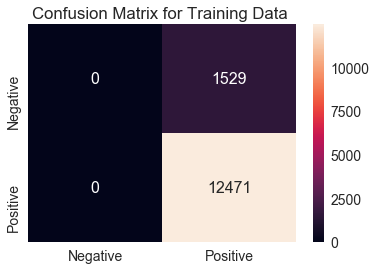

In [78]:
from sklearn.metrics import confusion_matrix,roc_curve
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

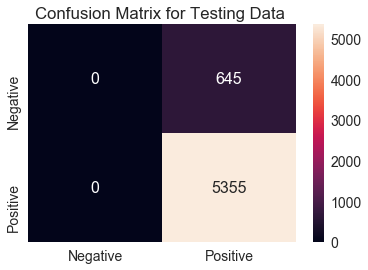

In [79]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### This Model is completely biased toward positive this is because we have taken less amount of data due to computational problem our model is not working

In [80]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR- {}".format(TPR))
print("FPR- {}".format(FPR))
print("TNR- {}".format(TNR))
print("FNR- {}".format(FNR))

TPR- 0.8925
FPR- nan
TNR- nan
FNR- 0.1075


### ROC AUC 

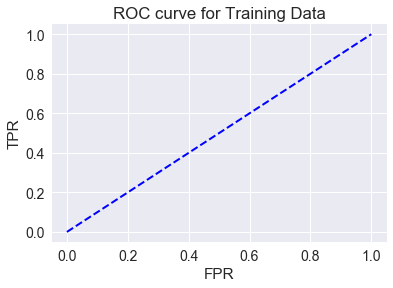

In [81]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

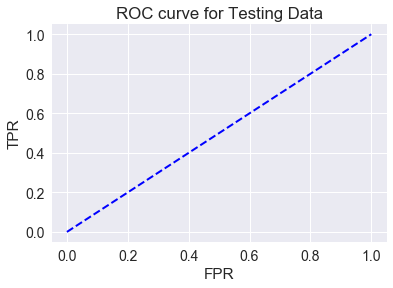

In [82]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

# TF-IDF Model

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
#TFIDF for Text 
tfidf_vect_text=TfidfVectorizer(max_features=500,min_df=10)
tfidf_X_train_text=tfidf_vect_text.fit_transform(X_train_text.values)
tfidf_X_test_text=tfidf_vect_text.transform(X_test_text.values)

#TFIDF for Summary
tfidf_vect_summary=TfidfVectorizer(max_features=30,min_df=10)
tfidf_X_train_summary=tfidf_vect_summary.fit_transform(X_train_summary.values)
tfidf_X_test_summary=tfidf_vect_summary.transform(X_test_summary.values)

from scipy.sparse import hstack

tfidf_X_train=hstack([tfidf_X_train_text,tfidf_X_train_summary])
tfidf_X_test=hstack([tfidf_X_test_text,tfidf_X_test_summary])

from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
tfidf_X_train=sc1.fit_transform(tfidf_X_train)
tfidf_X_test=sc1.transform(tfidf_X_test)

In [93]:
tuned_parameters = [{'C': [10**-2, 10**-1, 10**0, 10**1],'gamma': [10**-2, 10**-1, 10**0, 10**1]}]
model = GridSearchCV(SVC(kernel='rbf',class_weight='balanced'), tuned_parameters, scoring = 'roc_auc')
model.fit(tfidf_X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [94]:
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(tfidf_X_test, y_test))

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training_ROC_AUC_Score- 0.790212689393
Testing_ROC_AUC_Score- 0.822025058085


#### Optimal Value of C is 10

#### Optimal Value of gamma is 0.01

#### Testing ROC Score is 82.20%

#### Testing ROC score is greater than Training ROC score which shows our model is the dumbest model. this is due to the fact that we have taken a very less amount of data due to computational problem

### Accuracy Metrics 

In [95]:
classifier=model.best_estimator_
classifier.fit(tfidf_X_train,y_train)
pred_train=classifier.predict(tfidf_X_train)
pred_test=classifier.predict(tfidf_X_test)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 99.9857142857143%
Testing Accuracy- 89.23333333333333%
Training Error- 0.014285714285705353%
Testing Error- 10.766666666666666%


#### As both Training and Testing Error are low but we already know by roc score that our model is dumb that is the reason, we shouldn't use Accuracy as a performace measure when we have imbalanced data





In [104]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       645
          1       0.89      1.00      0.94      5355

avg / total       0.80      0.89      0.84      6000



#### This Model is completely biased toward positive reviews as its recall for negative review is zero, it is due to the less amount of data we have taken to do this classification 

### Confusion Matrix

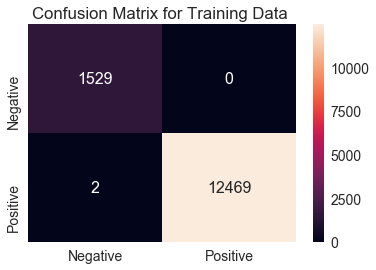

In [98]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

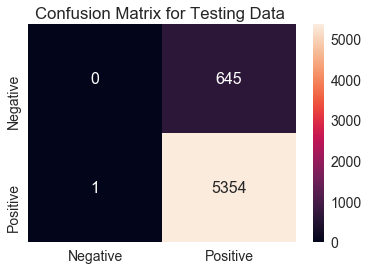

In [99]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### This Model is completely biased toward positive this is because we have taken less amount of data due to computational problem our model is not working

In [100]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.8924820803467245
FPR-1.0
TNR-0.0
FNR-0.10751791965327555


# Average Word2Vec Model

In [96]:
from gensim.models import Word2Vec
# Train Data for Text
list_of_sent_train_text=[]
for sent in X_train_text.values:
    list_of_sent_train_text.append(sent.split())
w2v_model_text=Word2Vec(list_of_sent_train_text,min_count=5,size=50, workers=4)
w2v_words_text = list(w2v_model_text.wv.vocab)
sent_vectors_train_text = []
for sent in tqdm(list_of_sent_train_text): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_text:
            vec = w2v_model_text.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_text.append(sent_vec)

# Test Data for Text
list_of_sent_test_text=[]
for sent in X_test_text.values:
    list_of_sent_test_text.append(sent.split())
sent_vectors_test_text = []
for sent in tqdm(list_of_sent_test_text): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_text:
            vec = w2v_model_text.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_text.append(sent_vec) 

#Train data for Summary
list_of_sent_train_summary=[]
for sent in X_train_summary.values:
    list_of_sent_train_summary.append(sent.split())
w2v_model_summary=Word2Vec(list_of_sent_train_summary,min_count=5,size=50, workers=4)
w2v_words_summary = list(w2v_model_summary.wv.vocab)
sent_vectors_train_summary = []
for sent in tqdm(list_of_sent_train_summary): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_summary:
            vec = w2v_model_summary.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_summary.append(sent_vec)

#Test data for Summary
list_of_sent_test_summary=[]
for sent in X_test_summary.values:
    list_of_sent_test_summary.append(sent.split())
sent_vectors_test_summary = []
for sent in tqdm(list_of_sent_test_summary): 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent:
        if word in w2v_words_summary:
            vec = w2v_model_summary.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_summary.append(sent_vec) 

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 20852.28it/s]


In [97]:
sent_vectors_train_text=np.array(sent_vectors_train_text)
sent_vectors_test_text=np.array(sent_vectors_test_text)
sent_vectors_train_summary=np.array(sent_vectors_train_summary)
sent_vectors_test_summary=np.array(sent_vectors_test_summary)

In [98]:
sent_vectors_train=np.hstack((sent_vectors_train_text,sent_vectors_train_summary))
sent_vectors_test=np.hstack((sent_vectors_test_text,sent_vectors_test_summary))

In [99]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
sent_vectors_train=sc1.fit_transform(sent_vectors_train)
sent_vectors_test=sc1.transform(sent_vectors_test)

In [100]:
tuned_parameters = [{'C': [10**-2, 10**-1, 10**0, 10**1],'gamma': [10**-2, 10**-1, 10**0, 10**1]}]
model = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'roc_auc')
model.fit(sent_vectors_train, y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(sent_vectors_test, y_test))

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training_ROC_AUC_Score- 0.856199594073
Testing_ROC_AUC_Score- 0.866972690885


#### Optimal Value of C is 10
#### Optimal Value of gamma is 0.01

#### Testing ROC Score is 86.69%
#### Testing ROC is greater than training roc which might show underfitting in model due to use of very small amout of data which is highly imbalanced


In [101]:
## Accuracy Metrics

In [102]:
classifier=model.best_estimator_
classifier.fit(sent_vectors_train,y_train)
pred_train=classifier.predict(sent_vectors_train)
pred_test=classifier.predict(sent_vectors_test)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 94.52857142857142%
Testing Accuracy- 90.9%
Training Error- 5.471428571428575%
Testing Error- 9.099999999999994%



#### we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 90.09%

In [103]:
## Classification Report

In [104]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.66      0.31      0.43       645
          1       0.92      0.98      0.95      5355

avg / total       0.89      0.91      0.89      6000



#### For Negative Reviews Recall is 0.31or 31% which means out of all Actual Negative Points we are just predicting 31% of negative correctly which is bad while in Positive Reviews we are predicting 98% of Reviews as Positive out of all Actual Positive Reviews



### Confusion Matrix

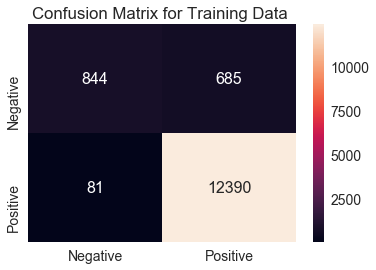

In [105]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

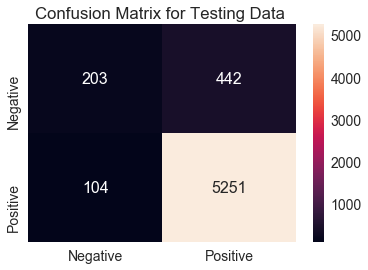

In [106]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 442 negative reviews are predicted as positive

#### This model is doing good job as compared to bag of words and tfidf as is able to distinguish between positive and negative reveiw

In [107]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.9223607939574917
FPR-0.33876221498371334
TNR-0.6612377850162866
FNR-0.07763920604250835


### ROC AUC 

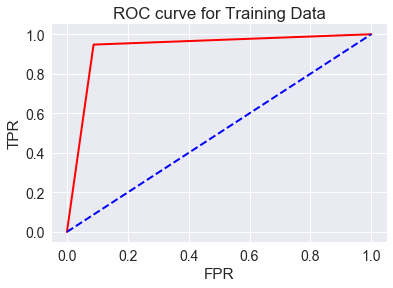

In [108]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

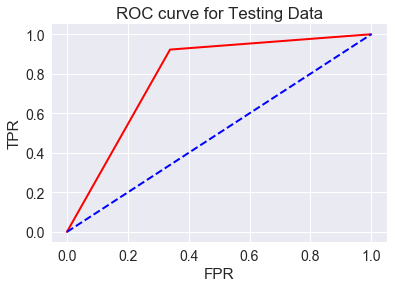

In [109]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

# TFIDF Word2Vec Model

In [110]:
model_text = TfidfVectorizer()
tf_idf_matrix_text = model_text.fit_transform(X_train_text.values)

dictionary = dict(zip(model_text.get_feature_names(), list(model_text.idf_)))

tfidf_feat_text = model_text.get_feature_names() 
tfidf_sent_vectors_train_text = []
for sent in tqdm(list_of_sent_train_text): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_text):
            vec = w2v_model_text.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train_text.append(sent_vec)
    
tf_idf_matrix_text = model_text.transform(X_test_text.values)

dictionary = dict(zip(model_text.get_feature_names(), list(model_text.idf_)))

tfidf_feat_text = model_text.get_feature_names() 
tfidf_sent_vectors_test_text = []
for sent in tqdm(list_of_sent_test_text): 
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if (word in w2v_words_text):
            vec = w2v_model_text.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test_text.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 826.36it/s]


In [111]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler(with_mean=False)
tfidf_sent_vectors_train_text=sc1.fit_transform(tfidf_sent_vectors_train_text)
tfidf_sent_vectors_test_text=sc1.transform(tfidf_sent_vectors_test_text)

In [112]:
tuned_parameters = [{'C': [10**-2, 10**-1, 10**0, 10**1],'gamma': [10**-2, 10**-1, 10**0, 10**1]}]
model = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'roc_auc')
model.fit(tfidf_sent_vectors_train_text, y_train)
print(model.best_estimator_)
print('Training_ROC_AUC_Score-',model.best_score_)
print('Testing_ROC_AUC_Score-',model.score(tfidf_sent_vectors_test_text, y_test))


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training_ROC_AUC_Score- 0.811947766848
Testing_ROC_AUC_Score- 0.822387828516


#### Optimal value of C is 10
#### Optimal value of gamma is 0.01
#### Testing ROC score is 0.82
#### As testing ROC score is greater than training , there might be underfitting as our data is very small, which can led to classifier not working correctly

In [113]:
## Accuracy Metrics

In [114]:
classifier=model.best_estimator_
classifier.fit(tfidf_sent_vectors_train_text,y_train)
pred_train=classifier.predict(tfidf_sent_vectors_train_text)
pred_test=classifier.predict(tfidf_sent_vectors_test_text)
accuracy_tfidf_train=accuracy_score(y_train,pred_train)*100
accuracy_tfidf_test=accuracy_score(y_test,pred_test)*100
print("Training Accuracy- {}%".format(accuracy_tfidf_train))
print("Testing Accuracy- {}%".format(accuracy_tfidf_test))
print("Training Error- {}%".format(100-accuracy_tfidf_train))
print("Testing Error- {}%".format(100-accuracy_tfidf_test))


Training Accuracy- 90.27857142857142%
Testing Accuracy- 89.78333333333333%
Training Error- 9.721428571428575%
Testing Error- 10.216666666666669%




##### we can't rely on simple Accuracy as our data is highly Imabalaced

#### Accuracy for Test data is 88.29%

In [115]:
## Classification Report

In [116]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.81      0.07      0.12       645
          1       0.90      1.00      0.95      5355

avg / total       0.89      0.90      0.86      6000



#### For Negative Reviews Recall is 0.07 or 7% which means out of all Actual Negative Points we are just predicting 7% of negative correctly which is bad while in Positive Reviews we are predicting 100% of Reviews as Positive out of all Actual Positive Reviews

#### This model is also very much biased towards positive class this is due to tha fact tha we have a very small amount of data

### Confusion Matrix

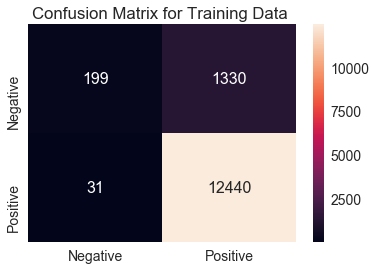

In [117]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_train,pred_train), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Training Data ')
plt.show()

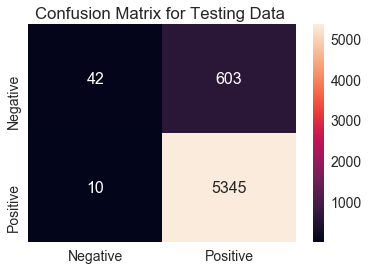

In [118]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test,pred_test), ["Negative", "Positive"],["Negative", "Positive"],dtype=int)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix for Testing Data ')
plt.show()

#### From Confusion Matrix We can see that we are predicting lot of negative reviews as positive 3045 negative reviews are predicted as positive

In [119]:
TN,FN,FP,TP = confusion_matrix(y_test, pred_test).ravel()

TPR = TP/(FN + TP)

FPR = FP/(TN + FP)

TNR = TN/(TN + FP)

FNR = FN/(FN + TP)

print("TPR-{}".format(TPR))
print("FPR-{}".format(FPR))
print("TNR-{}".format(TNR))
print("FNR-{}".format(FNR))

TPR-0.89862138533961
FPR-0.19230769230769232
TNR-0.8076923076923077
FNR-0.10137861466039005


### ROC AUC 

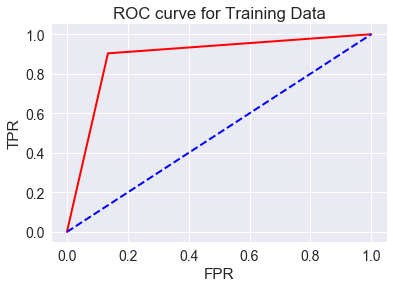

In [120]:
fpr, tpr,_=roc_curve(pred_train,y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Training Data')
plt.show()

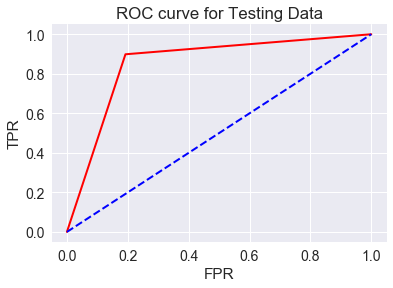

In [121]:
fpr, tpr,_=roc_curve(pred_test,y_test,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()

plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for Testing Data')
plt.show()

# Conclusions

* Most of the models are not working well with RBF SVC because we have used a very small data set which is highly imbalanced 
* But Avg Word2Vec is giving us some results
* Most of the models have test roc score higher than train this might show underfitting which is due to the use of small dataset
* I have tried using class weight='balanced' still it is not giving result which shows we require large amount of data to use SVC with RBF